In [196]:
import chaospy as ch
import sympy as sy
import numpy as np

In [197]:
sy.init_printing()

In [198]:
# from dask.distributed import Client

# client = Client("tcp://127.0.0.1:32871")
# client

In this version of the FODO cell notebook, the integration is not performed symbolically at the start but numerically at each timestep. This avoids having to calculate the Hamiltonian before starting and allows users to try PC expansions with more parameters/higher order, or using more complex starting Hamiltonians.
However, as it stands now it is slower than Monte Carlo.

There is no energy comparison or exponential map available, since these require a symbolic Hamiltonian.

At the end there are a few experiments about using code transform libraries such as `jax` to avoid this numerical calculation and instead use external numerical code such as `DA`. However, it seems the
functions able to be differentiated have to have a very simple form. 

## Definitions

In [199]:
q0, q1 = ch.variable(2)
s0, s1, s2 = sy.symbols("s0 s1 s2",real=True)
k0, k1, k2, k3 = sy.symbols("k0 k1 k2 k3") # D PCE degree
D, O = sy.symbols("D O", nonnegative=True, integer=True) # D dimension, O pce degree

px, py, dl = sy.symbols('p_x p_y δ', real=True)
x, y, z = sy.symbols('x y z', real=True)

t = sy.symbols('t', real=True)

Q = sy.IndexedBase('Q', shape=(D,O), real=True)
P = sy.IndexedBase('P', shape=(D,O), real=True)

# "Abstract" polynomial, psi(i, Xi) represents the ith orthogonal polynomial in Xi
psi = sy.Function('ψ', real=True)

ii = sy.Idx('ii')
jj = sy.Idx('jj')

## Hamiltonian of FODO cell:
\begin{equation}
H = -\sqrt{\left( \frac{1}{\beta_0} +\delta \right)^2 - p_x^2 - p_y^2 - \frac{1}{\beta_0^2\gamma_0^2}} \, +\, \frac{1}{6} \left( k_3x^3-k_2xy^2 \right) \,+\, \frac{\delta}{\beta_0}.
\end{equation}


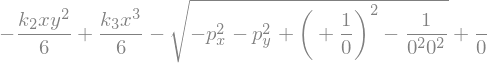

In [200]:
s0, s1, b0, g0 = sy.symbols("s0 s1 β0 γ0",real=True)
gamma_def = 1/sy.sqrt(1-b0**2)
test_multivar_expr = sy.sqrt(s0**2+s1**2)

b0_value = 0.99

#test_multivar_expr = sy.exp(s0+s1)
#test_multivar_expr

full_fodo_ham = -sy.sqrt((1/b0+dl)**2-px**2-py**2-1/(b0*g0)**2)+1/sy.Number(6)*(k3*x**3-k2*x*y**2)+dl/b0
full_fodo_ham

#https://stackoverflow.com/questions/22857162/multivariate-taylor-approximation-in-sympy
# test_order = 3
# test_raw_exp = sy.expand(test_multivar_expr.series(s0, 0, test_order).removeO().series(s1, 0, test_order).removeO())
# test_raw_exp

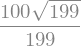

In [201]:
gamma_def.subs(b0, 1-1/sy.Number(100))

In [202]:
# https://stackoverflow.com/a/63850672
def Taylor_polynomial_sympy(function_expression, variable_list, evaluation_point, degree):
    """
    Mathematical formulation reference:
    https://math.libretexts.org/Bookshelves/Calculus/Supplemental_Modules_(Calculus)/Multivariable_Calculus/3%3A_Topics_in_Partial_Derivatives/Taylor__Polynomials_of_Functions_of_Two_Variables
    :param function_expression: Sympy expression of the function
    :param variable_list: list. All variables to be approximated (to be "Taylorized")
    :param evaluation_point: list. Coordinates, where the function will be expressed
    :param degree: int. Total degree of the Taylor polynomial
    :return: Returns a Sympy expression of the Taylor series up to a given degree, of a given multivariate expression, approximated as a multivariate polynomial evaluated at the evaluation_point
    """
    from sympy import factorial, Matrix, prod
    import itertools

    n_var = len(variable_list)
    point_coordinates = [(i, j) for i, j in (zip(variable_list, evaluation_point))]  # list of tuples with variables and their evaluation_point coordinates, to later perform substitution

    deriv_orders = list(itertools.product(range(degree + 1), repeat=n_var))  # list with exponentials of the partial derivatives
    deriv_orders = [deriv_orders[i] for i in range(len(deriv_orders)) if sum(deriv_orders[i]) <= degree]  # Discarding some higher-order terms
    n_terms = len(deriv_orders)
    deriv_orders_as_input = [list(sum(list(zip(variable_list, deriv_orders[i])), ())) for i in range(n_terms)]  # Individual degree of each partial derivative, of each term

    polynomial = 0
    for i in range(n_terms):
        partial_derivatives_at_point = function_expression.diff(*deriv_orders_as_input[i]).subs(point_coordinates)  # e.g. df/(dx*dy**2)
        denominator = prod([factorial(j) for j in deriv_orders[i]])  # e.g. (1! * 2!)
        distances_powered = prod([(Matrix(variable_list) - Matrix(evaluation_point))[j] ** deriv_orders[i][j] for j in range(n_var)])  # e.g. (x-x0)*(y-y0)**2
        polynomial += partial_derivatives_at_point / denominator * distances_powered
    return polynomial

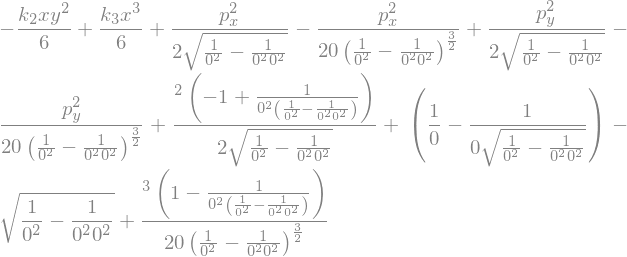

In [203]:
Taylor_polynomial_sympy(full_fodo_ham, [x,y,z,px,py,dl], [0,0,0,0,0,0], degree=3)

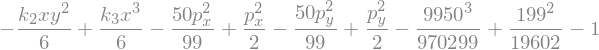

In [204]:
taylor_ham = Taylor_polynomial_sympy(full_fodo_ham, [x,y,z,px,py,dl], [0,0,0,0,0,0], degree=3) \
                .subs(g0,gamma_def).subs(b0,sy.nsimplify(b0_value))
taylor_ham

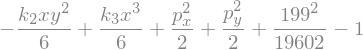

In [205]:
taylor_ham2 = Taylor_polynomial_sympy(full_fodo_ham, [px,py,dl], [0,0,0],  degree=2) \
                .subs(g0,gamma_def).subs(b0,sy.nsimplify(b0_value))
taylor_ham2

### Test accuracy

In [206]:
vf = 2#variables' multiplicative factor
h_var_subs = [(x,vf*0.1),(y,vf*0.1),(px,vf*0.1),(py,vf*0.1),(dl,vf*0.1),(b0,b0_value),(k2,1),(k3,1)]
ffh = full_fodo_ham.subs(g0,gamma_def).subs(h_var_subs)
th = taylor_ham.subs(g0,gamma_def).subs(h_var_subs)
th2 = taylor_ham2.subs(g0,gamma_def).subs(h_var_subs)

print("H: ",ffh)
print("H3: ",th)
print("H3_2: ",th2)
print("Relative errors: ")
print("H3: ",  abs(1-th/ffh)*100, "%")
print("H3_2: ",abs(1-th2/ffh)*100, "%")

H:  -0.965901201174552
H3:  -0.967756763636776
H3_2:  -0.959593918987858
Relative errors: 
H3:  0.192106859373098 %
H3_2:  0.652994548409747 %


## Polynomials
### Chaospy to sympy

In [207]:
poly = 5*q0**2+4*q0+3*q1+2*q0*q1-1
poly.names[0][1:]

'0'

In [208]:
terms = [poly.coefficients[j]*s0**poly.exponents[j,0]*s1**poly.exponents[j,1] 
         for j in range(len(poly.exponents))]
poly_sympy = sum(terms)
poly_sympy

In [209]:
def ch_to_sy(ch_poly, norm = None):
    sy_tolerance = 10**-10
    num_vars = len(ch_poly.indeterminants)
    num_terms = len(ch_poly.coefficients)
    # Make vars
    sy_vars = []
    #print(ch_poly.names)
    for ch_var_id in [ch_poly.names[i][1:] for i in range(num_vars)]:
        #print(ch_var_id)
        sy.var(f"s{ch_var_id}")
        sy_vars.append(globals()[f"s{ch_var_id}"])
    
    terms = [ch_poly.coefficients[j]*sy.prod([sy_vars[i]**ch_poly.exponents[j,i] 
                          for i in range(num_vars)]) for j in range(num_terms)]
    # nsimplify approximates the float numbers into simpler exact representations
    # https://docs.sympy.org/latest/modules/simplify/simplify.html#nsimplify
    if norm is None:
        poly = sy.nsimplify(sum(terms), full=False, tolerance = sy_tolerance)
    else:
        poly = sy.nsimplify(sum(terms), full=False, tolerance = sy_tolerance) / \
        sy.sqrt(sy.nsimplify(norm, full=False, tolerance = sy_tolerance))
    return poly

### Gram-Schmidt directly in sympy

In [210]:
def sy_EV(integrand, density, domain):
    out = sy.integrate(integrand * density, *domain)
    return out

In [211]:
from functools import reduce
import operator
def sympy_orthopoly_gs(order, pdfs, domain, normed=True):
    """
    Make orthogonal polynomials directly in sympy.
    Adapted from:
        chaospy.readthedocs.io/en/master/_modules/chaospy/orthogonal/gram_schmidt.html#orth_gs
    
    order: Max polynomial order
    pdfs: array of functions/pdfs P(Xi_i) for each germ
    domain: only cartesian prod of germ intervals, some may be infinite.
    
    """
    n_vars = len(pdfs)
    assert(n_vars==len(domain))
    
    if order == 0:
            return ch_to_sy(ch.polynomial(1))
    basis = ch.monomial(
            0,
            order+1,
            names=ch.variable(n_vars).names,
            graded=True,
            reverse=True,
            cross_truncation=1.,)
    basis = list(ch_to_sy(basis))
    #print(basis)
    sy_vars = ch_to_sy(ch.variable(n_vars))
    polynomials = [basis[0]]
    
    pdfs_expr = [pdfs[i](sy_vars[i]) 
                 for i in range(len(sy_vars))]
    total_pdf_expr = reduce(operator.mul, pdfs_expr, 1)
    
    norms = [1]
    for idx in range(1, len(basis)):
        # orthogonalize polynomial:
        for idy in range(idx):
            orth = sy_EV(basis[idx]*polynomials[idy], total_pdf_expr, domain)
            basis[idx] = basis[idx]-polynomials[idy]*orth/norms[idy]

        norms_ = sy_EV(basis[idx]**2, total_pdf_expr, domain)

        norms.append(1 if normed else norms_)
        basis[idx] = basis[idx]/sy.sqrt(norms_) if normed else basis[idx]
        polynomials.append(basis[idx])

    return polynomials, norms

### Tests

In [212]:
#sy.var('x0:2')

In [213]:
ch_to_sy(poly, norm=None)


In [214]:
[globals()[f"s{i}"] for i in range(0,2)]

In [215]:
sy.sympify(2.976)*0.3

In [216]:
"q123"[1:]

'123'

## Hamiltonian expansions

### Definitions

In [217]:
def gaussdensity(x, mu, sigma, numerical=False):
    if numerical:
        return 0.398942280401433*sy.exp(-0.5*((x-mu)/sigma)**2)
    else:
        return sy.Number(1)/(sigma*sy.sqrt(2*sy.pi))*sy.exp(-sy.Number(1)/2*((x-mu)/sigma)**2 )

In [218]:
lowerb1 = sy.nsimplify(1.5)
upperb1 = sy.nsimplify(3.5)
distribution1 = ch.Uniform(lower=float(lowerb1), upper=float(upperb1))
uniform_density1 = lambda xi: 1/(upperb1-lowerb1)

# # GAUSS(3,1)
# lowerb = -sy.oo
# upperb = sy.oo
# mu = 3
# sigma = 1
# distribution = ch.Normal(mu=mu, sigma=sigma)

# # GAUSS(0,1)
# lowerb2 = -sy.oo
# upperb2 = sy.oo
# mu = 0
# sigma = 1
# distribution2 = ch.Normal(mu=mu, sigma=sigma)

lowerb2 = sy.nsimplify(3)
upperb2 = sy.nsimplify(4)
distribution2 = ch.Uniform(lower=float(lowerb2), upper=float(upperb2))
uniform_density2 = lambda xi: 1/(upperb2-lowerb2)

lowerb3 = sy.nsimplify(0.01)
upperb3 = sy.nsimplify(0.04)
distribution3 = ch.Uniform(lower=float(lowerb3), upper=float(upperb3))
uniform_density3 = lambda xi: 1/(upperb3-lowerb3)


#Multivar!
ch_distribution_list = [distribution1, distribution2, distribution3]
distribution = ch.J(*ch_distribution_list)
sy_dist_pdf_list = [uniform_density1, uniform_density2, uniform_density3]
sy_dist_pdf = lambda xi1, xi2, xi3: uniform_density1(xi1)*uniform_density2(xi2)*uniform_density3(xi3)
sy_omega = [(s0,lowerb1,upperb1),(s1,lowerb2,upperb2),(s2,lowerb3,upperb3)] # Xi square domain for sympy integration
#sy_distribution = sy.Product(var_distributions[i],(ii,0,)


In [219]:
polynomial_order = 1

polynomial_expansion, poly_norms = ch.orth_ttr(polynomial_order, distribution, retall=True)

num_germ_vars = 3
#num_terms = polynomial_order+1
num_polys = len(polynomial_expansion)

print(polynomial_expansion)
len(polynomial_expansion)

[1.0 q2-0.025 q1-3.5 q0-2.5]


In [220]:
ch.orth_gs(polynomial_order, distribution, retall=True)

(polynomial([1.0, q1-3.5, q0-2.5]),
 array([1.        , 0.08333333, 0.33333333]))

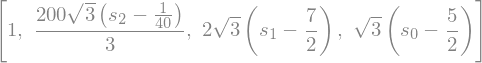

In [221]:
sy_polys = [ch_to_sy(polynomial_expansion[i], poly_norms[i]) for i in range(num_polys)]
#sy_polys = [ch_to_sy(polynomial_expansion[i], None) for i in range(num_polys)]


#polynomial_expansion[3]
sy_polys

In [222]:
%%time
#[(s0,lowerb1,upperb1),(s1,lowerb1,upperb1)]
orthpoly_test, orthpoly_norms = sympy_orthopoly_gs(polynomial_order, 
                                   sy_dist_pdf_list, 
                                   sy_omega)

sy_omega = [(s0,lowerb1,upperb1),(s1,lowerb2,upperb2),(s2,lowerb3,upperb3)] 
orthpoly_test, orthpoly_norms = sympy_orthopoly_gs(polynomial_order, 
                                   sy_dist_pdf_list, 
                                   sy_omega)
# orthpoly_test = sympy_orthopoly_gs(4, 
#                                    [uniform_density, uniform_density], 
#                                    [(s0,lowerb1,upperb1),(s1,lowerb1,upperb1)],
#                                    normed=True)
print(orthpoly_test == sy_polys)
orthpoly_norms

True
CPU times: user 410 ms, sys: 8.02 ms, total: 418 ms
Wall time: 414 ms


In [223]:
# print(len(orthpoly_test))
# sy.integrate(orthpoly_test[19]*orthpoly_test[20] * sy_dist_pdf(s0,s1), *sy_omega)
sy_polys = orthpoly_test
poly_norms = orthpoly_norms
#poly_norms = np.array([float(n) for n in orthpoly_norms])

In [224]:
#ch_to_sy(polynomial_expansion[4], poly_norms[4])


### Polynomials are orthogonal

In [225]:
# Uniform
sy.integrate(sy_polys[1]*sy_polys[1] * sy_dist_pdf(s0,s1,s2), *sy_omega)
#sy.integrate(sy_dist_pdf(s0,s1), *sy_omega)

# Gaussian
#sy.integrate(sy_polys[3]*sy_polys[3] * gaussdensity(s0,mu,sigma) ,(s0,lowerb,upperb))

### Hamiltonian

In [226]:
# Uniform
# lowerb = sy.nsimplify(1.5)
# upperb = sy.nsimplify(3.5)
# distribution = ch.Uniform(lower=float(lowerb), upper=float(upperb))
# uniform_density = lambda xi: 1/(upperb-lowerb)

# # Gaussian
# # lowerb = -sy.oo
# # upperb = sy.oo
# # mu = 3
# # sigma = 2
# # distribution = ch.Normal(mu=mu, sigma=sigma)

# polynomial_order = 4
# num_terms = polynomial_order+1

#polynomial_expansion, poly_norms = ch.orth_ttr(polynomial_order, distribution, retall=True)
h_dims = 3 # Number of space dimensions, eg 3=x,y,z and 3 momenta px py pz 

# sy_norms = [sy.nsimplify(poly_norms[i]) for i in range(num_polys)]

#sy_polys_orig_unnorm = [ch_to_sy(polynomial_expansion[i]) for i in range(num_terms)]
# sy_polys_orig = [ch_to_sy(polynomial_expansion[i],poly_norms[i]) for i in range(num_polys)]
sy_polys_orig = sy_polys
sy_norms = poly_norms 

print(sy_polys_orig)

#sy_norms
len(sy_polys_orig)

[1, 200*sqrt(3)*(s2 - 1/40)/3, 2*sqrt(3)*(s1 - 7/2), sqrt(3)*(s0 - 5/2)]


In [227]:
# Hamiltonian
def H1(q,p,k0):
    return sy.Number(1)/2*p**2+sy.Number(1)/2*k0*q**2

def H1_func(q,p,k0):
    return 1/2*p**2+1/2*k0*q**2

def H3(q,p,k0):
    return sy.Number(1)/2*p**2 - sy.Number(1)/2*k0*q**2+sy.Number(1)/4*q**4

def Hrel(q,p,k0):
    return sy.sqrt(p**2+1) + sy.Number(1)/2*k0*q**2

Hrel_taylor_sy = Taylor_polynomial_sympy(full_fodo_ham, [x,y,z,px,py,dl], [0,0,0,0,0,0], degree=3).subs(g0,gamma_def)
def Hfodo(xv,yv,zv,pxv,pyv,dlv, k2v,k3v,b0v):
    h_var_subs = [(x,xv),(y,yv),(z,zv),(px,pxv),(py,pyv),(dl,dlv),(b0,b0v),(k2,k2v),(k3,k3v)]
    return Hrel_taylor_sy.subs(h_var_subs)
# Hrel_taylor_num = sy.lambdify([x,y,z,px,py,pz], Hrel_taylor_sy, 
#                                dummify = None, modules=["scipy", "numpy"])

# Get concrete polynomial expansion
def psic(i, *args):
    #print(args)
    # Should receive as many args as germ variables
    orig_vars = [globals()[f"s{j}"] for j in range(len(args))]
    varsubs = [(orig_vars[j], args[j]) for j in range(len(args))]
    return sy_polys_orig[i].subs(varsubs)

In [228]:
### PCE Expansion

#PCE germ variable xi
xi0 = s0
xi1 = s1
xi2 = s2

PCEvars_list = [Z[i,j] for Z in (Q,P) for i in range(h_dims) for j in range(num_polys)]
PCEvars_list

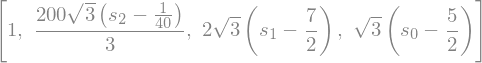

In [229]:
Ham = Hfodo

# Get subset of full PCE expansion, for parallelization
def series_range(z_var, low=0, high=num_polys):
    return sum([z_var[i]*psic(i,xi0,xi1,xi2) for i in range(low,high)])

def series_range_ND(z_var, dim, low=0, high=num_polys):
    return sum([z_var[dim,i]*psic(i,xi0,xi1,xi2) for i in range(low,high)])

# qqcc = sum([Q[i]*psic(i,xi0,xi1) for i in range(num_polys)])
# ppcc = sum([P[i]*psic(i,xi0,xi1) for i in range(num_polys)])

qq_arr = [series_range_ND(Q, dim, 0, num_polys)#.evalf()
              for dim in range(h_dims)]
pp_arr = [series_range_ND(P, dim, 0, num_polys)#.evalf()
              for dim in range(h_dims)]
sy_polys_orig

In [230]:
%%time
#Ham_poly = sy.Poly(Ham(q=qqcc,p=ppcc,k0=s0)*sy_dist_pdf(s0,s1).evalf().simplify(),PCEvars_list)
#parallel_poly_from_expr
Ham_poly = sy.Poly(Ham(xv=qq_arr[0],yv=qq_arr[1],zv=qq_arr[2],
                       pxv=pp_arr[0],pyv=pp_arr[1],dlv=pp_arr[2], 
                       k2v=s0,
                       k3v=s1,b0v=sy.nsimplify(b0_value)),PCEvars_list)
#Ham_poly;
#Ham_poly
#Ham_poly2 = sy.Poly(Ham(q=qqcc,p=ppcc,k0=s0),[s0,s1])

CPU times: user 533 ms, sys: 4.01 ms, total: 537 ms
Wall time: 535 ms


In [231]:
#sum(Ham_poly.as_expr().args[:]) == Ham_poly.as_expr()
#Ham_poly

In [232]:
%%time
#sy.diff(H1(qqc,ppc,k0),Q[1])
#sy.diff(H1(qqcc,ppcc,k0),Q[0])


# # LONG! Integrate Hamiltonian step 1: substitute Polynomials in variables
# # Times: 2h1m for O=5, ~3h for Ham3_2 O=3, ~5:55 for H3, O=3

Ham_expr = Ham(xv=qq_arr[0],yv=qq_arr[1],zv=qq_arr[2],
                       pxv=pp_arr[0],pyv=pp_arr[1],dlv=pp_arr[2], 
                       k2v=s0,
                       k3v=s1,
                       b0v=sy.nsimplify(b0_value))

CPU times: user 1.46 ms, sys: 16 µs, total: 1.48 ms
Wall time: 1.48 ms


In [233]:
#Ham_expr

In [234]:
%%time
# # LONG! Continued, integrate Hamiltonian step 2: do integral
#Htilde = sy.integrate(Ham_expr*sy_dist_pdf(s0,s1), *sy_omega)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [235]:
#WRITE TO FILE
# from pathlib import Path
# Path(f"Hhat_d{h_dims}_o{polynomial_order}_srepr.txt").write_text(sy.srepr(Htilde))



#READ FROM FILE
# from pathlib import Path
# Htilde_str = Path(f"Hhat_d{h_dims}_o{polynomial_order}_srepr.txt").read_text()
# Htilde = sy.sympify(Htilde_str)
#Htilde-Htilde2

In [236]:
# from pathlib import Path
# Htilde_str = Path('Hhat_5_srepr.txt').read_text()
# Htilde_str
#Htilde

In [237]:
%%time
#sy.srepr(Htilde)
# Htilde_simp = sy.nsimplify(Htilde.evalf(),full=False,tolerance=1e-7)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs


In [238]:
#Htilde_simp.evalf()

#WRITE TO FILE
# from pathlib import Path
# Path(f"Hhat_SIMP_d{h_dims}_o{polynomial_order}_srepr.txt").write_text(sy.srepr(Htilde_simp))



#READ FROM FILE
# from pathlib import Path
# Htilde_simp_str = Path(f"Hhat_SIMP_d{h_dims}_o{polynomial_order}_srepr.txt").read_text()
# Htilde_simp = sy.sympify(Htilde_simp_str)
#Htilde_simp-Htilde_simp2

In [239]:
%%time
# DASK VERSION
# import dask as dk
# #dk.config.set(scheduler='processes')

# num_cores = 8
# single_pieces_num = len(Ham_poly.as_expr().args)
# pieces_per_thread = single_pieces_num // num_cores # TODO To make also for non perfect ratio!
# remaining_pieces = single_pieces_num % num_cores
# #pieces_per_thread = 1
# Ham_poly_pieces = [sum(Ham_poly.as_expr().args[i*pieces_per_thread:(i+1)*pieces_per_thread]) 
#                    for i in range(num_cores)]
# for r in range(remaining_pieces):
#     Ham_poly_pieces[r] = Ham_poly_pieces[r] + Ham_poly.as_expr().args[num_cores*pieces_per_thread+r]
    
# #Ham_poly_pieces = Ham_poly.as_expr().args
# Htilde_pieces = []
# print(len(Ham_poly_pieces))
# print()
# print(single_pieces_num)
# print(pieces_per_thread)
# print(remaining_pieces)
# Ham_poly_pieces;

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


In [240]:
# %%time
# for i in range(len(Ham_poly_pieces)):
#     Htilde_piece = dk.delayed(
#         sy.integrate)(Ham_poly_pieces[i]*sy_dist_pdf(s0,s1), *sy_omega)
#     Htilde_pieces.append(Htilde_piece)
# Htilde2 = dk.delayed(sum)(Htilde_pieces)
# Ht2 = Htilde2.compute()

In [241]:
#Ht2

In [242]:
#Htilde

In [243]:
#Htilde-Ht2
#Htilde == Ht2
#sy.simplify(Htilde-Ht2)
#sy.diff(Htilde,Q[0])

In [244]:
#sy.diff(sy.integrate(H1(qq,pp,k0),k0),Q[ii])

In [245]:
deriv_sign = {P: 1, Q: -1}

#deriv_array_non_norm = [deriv_sign[Z]*sy.diff(Htilde,Z[i,j]) for Z in (P,Q) for i in range(h_dims) for j in range(num_polys)]
deriv_array_non_norm = [deriv_sign[Z]*sy.diff(Ham_expr,Z[i,j]) for Z in (P,Q) for i in range(h_dims) for j in range(num_polys)]


In [246]:
#print([sy_norms[i%num_terms] for i in range(2*num_terms)])

##deriv_array = [deriv_array_non_norm[i]/sy_norms[i%num_terms] for i in range(2*num_terms)]
deriv_array = deriv_array_non_norm
print(len(deriv_array))
deriv_array[-1]

24


In [247]:
# sy.var(f"Qf0:{num_polys}", cls=sy.Function, real = True)
# sy.var(f"Pf0:{num_polys}", cls=sy.Function, real = True)

# funcs_list = [globals()[f"Qf{i}"](t) for i in range(num_polys)] + \
#              [globals()[f"Pf{i}"](t) for i in range(num_polys)]
# subs_list_Q = [(Q[i], globals()[f"Qf{i}"](t)) for i in range(num_polys)]
# subs_list_P = [(P[i], globals()[f"Pf{i}"](t)) for i in range(num_polys)]
# subs_list = subs_list_Q + subs_list_P
# print(subs_list)

# deriv_array_with_functions = [deriv_array[i].subs(subs_list).simplify() for i in range(2*num_polys)]
# equations_Q = [sy.Eq(sy.Derivative(globals()[f"Qf{i}"](t),t), deriv_array_with_functions[i]) for i in range(num_polys)]
# equations_P = [sy.Eq(sy.Derivative(globals()[f"Pf{i}"](t),t), deriv_array_with_functions[num_polys+i]) for i in range(num_polys)]
# equations = equations_Q+equations_P
# for e in equations:
#     sy.pprint(e)

In [248]:
### Initial conditions
# (Q(0)=1,P(0)=0)
t0 = 0.

#############
# Numerical initcond
# numeric_initconds=True
# init_cond_q = [sy.nsimplify(0.05), sy.nsimplify(0.05), 0]
# init_cond_p = [-sy.nsimplify(0.01), -sy.nsimplify(0.01), -sy.nsimplify(0.01)]
#############

#############
# Stochastic initcond
# GOOD SET!
# numeric_initconds=False
# init_cond_q = [sy.nsimplify(0.5)*xi1, sy.nsimplify(0.05), 0]
# init_cond_p = [-sy.nsimplify(0.01), -sy.nsimplify(0.01), -sy.nsimplify(0.01)]
#############

#############
# Stochastic initcond
numeric_initconds=False
init_cond_q = [xi2, sy.nsimplify(0.05), 0]
init_cond_p = [-sy.nsimplify(0.01), -sy.nsimplify(0.01), -sy.nsimplify(0.01)]
#############

#Htilde = sy.integrate(Ham(q=qqcc,p=ppcc,k0=s0)*sy_dist_pdf(s0,s1), *sy_omega).simplify()

#############
# Numerical initcond
print(sy_norms)
init_cond_pce_q = [sy.integrate(init_cond_q[i]*psic(j,xi0,xi1,xi2)*sy_dist_pdf(xi0,xi1,xi2), *sy_omega)/sy_norms[j] for i in range(h_dims) for j in range(num_polys)]
init_cond_pce_p = [sy.integrate(init_cond_p[i]*psic(j,xi0,xi1,xi2)*sy_dist_pdf(xi0,xi1,xi2), *sy_omega)/sy_norms[j] for i in range(h_dims) for j in range(num_polys)]

#############

init_cond_pce = init_cond_pce_q+init_cond_pce_p
print(init_cond_pce)

#init_cond_pce_sympy = {f(x0): x1}
# init_cond_pce_sympy_q = {globals()[f"Qf{i}"](t0): init_cond_pce_q[i] for i in range(num_polys)}
# init_cond_pce_sympy_p = {globals()[f"Pf{i}"](t0): init_cond_pce_p[i] for i in range(num_polys)}
# init_cond_pce_sympy = {**init_cond_pce_sympy_q, **init_cond_pce_sympy_p}
# init_cond_pce_sympy

init_cond_pce = [float(init_cond_pce[i]) for i in range(len(init_cond_pce))]
init_cond_pce
# Htilde = sy.integrate(Ham(qqcc,ppcc,k0)*uniform_density(xi),(xi, lowerb, upperb))
# Htilde


[1, 1, 1, 1]
[1/40, sqrt(3)/200, 0, 0, 1/20, 0, 0, 0, 0, 0, 0, 0, -1/100, 0, 0, 0, -1/100, 0, 0, 0, -1/100, 0, 0, 0]


## Numerical solution

In [249]:
import scipy as sp
import numpy as np

In [250]:
deriv_array
#[sy.lambdify(t, deriv_array[i], modules=["scipy", "numpy"]) for i in range(num_terms)] 
#from sympy.utilities.lambdify import lambdastr
# pce_coeffs_var_list = [Q[i] for i in range(num_terms)] + \
#                       [P[i] for i in range(num_terms)]
#pce_coeffs_var_list = [Z[i] for Z in (Q,P) for i in range(num_polys)]
print(PCEvars_list)
test = sy.lambdify(PCEvars_list, deriv_array[3], dummify = None, modules=["scipy", "numpy"])
#print(test(1.,2, 0, 0))

#test_tuple = [1.,2, 0, 0]
#print(test(*test_tuple))

# Old ways:
# deriv_array_numeric = [
#     sy.lambdify(PCEvars_list, deriv_array[i].evalf(), dummify = None, modules=["scipy", "numpy"]) 
#                       for i in range(len(deriv_array))]


# test_num = sy.lambdify([[s0,s1],PCEvars_list],deriv_array[0].evalf(), modules=["scipy", "numpy"])
germs_list = [xi0,xi1,xi2]
assert(len(germs_list) == num_germ_vars)
quadrature_order = 3
abscissas, weights = ch.generate_quadrature(order=quadrature_order, dist=distribution)
print("shape abscissas: ", abscissas.shape)
deriv_array_noE_lambdas = [sy.lambdify([germs_list,PCEvars_list], deriv_array[i].evalf(), modules=["scipy", "numpy"]) for i in range(len(deriv_array))]
deriv_array_numeric = lambda i, PCEvars, abscissas, weights: np.sum(weights*deriv_array_noE_lambdas[i](abscissas,PCEvars))

#len(deriv_array_numeric)

[Q[0, 0], Q[0, 1], Q[0, 2], Q[0, 3], Q[1, 0], Q[1, 1], Q[1, 2], Q[1, 3], Q[2, 0], Q[2, 1], Q[2, 2], Q[2, 3], P[0, 0], P[0, 1], P[0, 2], P[0, 3], P[1, 0], P[1, 1], P[1, 2], P[1, 3], P[2, 0], P[2, 1], P[2, 2], P[2, 3]]
shape abscissas:  (3, 64)


In [251]:
import inspect
print(inspect.getsource(deriv_array_noE_lambdas[0]))
deriv_array_numeric(0,init_cond_pce, abscissas, weights)

def _lambdifygenerated(_Dummy_2624, _Dummy_2625):
    [s0, s1, s2] = _Dummy_2624
    [Dummy_2611, Dummy_2610, Dummy_2609, Dummy_2608, Dummy_2607, Dummy_2606, Dummy_2605, Dummy_2604, Dummy_2603, Dummy_2602, Dummy_2601, Dummy_2600, Dummy_2623, Dummy_2622, Dummy_2621, Dummy_2620, Dummy_2619, Dummy_2618, Dummy_2617, Dummy_2616, Dummy_2615, Dummy_2614, Dummy_2613, Dummy_2612] = _Dummy_2625
    return (1.73205080756888*Dummy_2620*(s0 - 2.5) + 3.46410161513775*Dummy_2621*(s1 - 3.5) + 115.470053837925*Dummy_2622*(s2 - 0.025) + Dummy_2623 + (1.73205080756888*Dummy_2612*(s0 - 2.5) + 3.46410161513775*Dummy_2613*(s1 - 3.5) + 115.470053837925*Dummy_2614*(s2 - 0.025) + Dummy_2615)*(-1.74954627027159*Dummy_2620*(s0 - 2.5) - 3.49909254054319*Dummy_2621*(s1 - 3.5) - 116.636418018106*Dummy_2622*(s2 - 0.025) - 1.01010101010101*Dummy_2623))



In [252]:
def derivative_field(t, y, *args):
    abscissas, weights = args
    return np.array([deriv_array_numeric(i, y, abscissas, weights) for i in range(len(deriv_array_noE_lambdas))])
print(init_cond_pce)
derivative_field(0., init_cond_pce, abscissas, weights)
#type(init_cond_pce[0])

[0.025, 0.008660254037844387, 0.0, 0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01, 0.0, 0.0, 0.0, -0.01, 0.0, 0.0, 0.0, -0.01, 0.0, 0.0, 0.0]


array([-1.01010101e-02,  0.00000000e+00,  1.30104261e-18,  1.37134634e-18,
       -1.01010101e-02,  0.00000000e+00,  1.30104261e-18,  1.37134634e-18,
       -3.07126978e-04,  0.00000000e+00,  5.42101086e-20,  4.35957270e-20,
       -1.83333333e-04, -7.57772228e-04, -1.01036297e-04,  2.40562612e-04,
        1.04166667e-03,  3.60843918e-04, -1.08420217e-19,  2.40562612e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [257]:
%%time
t0 = 0.
tf = 8.
t_span = (t0, tf)
y0 = init_cond_pce

time_steps = 1000
tcoordinates = np.linspace(t_span[0], t_span[1], time_steps)
sol = sp.integrate.solve_ivp(derivative_field, t_span, y0, method='DOP853', rtol=1e-11, atol=1e-11, max_step=1./1000, t_eval=tcoordinates, dense_output=True, events=None, vectorized=False, args=[abscissas, weights])
z_approx_coeffs = sol.sol(tcoordinates).T
z_approx_coeffs[:,:]

CPU times: user 1min 41s, sys: 87.3 ms, total: 1min 41s
Wall time: 1min 41s


array([[ 2.50000000e-02,  8.66025404e-03,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.49191051e-02,  8.66022952e-03, -3.26606182e-09, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.48381986e-02,  8.66015608e-03, -1.30390740e-08, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-6.70398472e-02,  8.18218799e-03, -2.65755273e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.72099757e-02,  8.20316250e-03, -2.67163573e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.73806166e-02,  8.22425674e-03, -2.68580260e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [258]:
x_approx  = ch.sum(polynomial_expansion*z_approx_coeffs[:,0*num_polys:1*num_polys], -1)
y_approx  = ch.sum(polynomial_expansion*z_approx_coeffs[:,1*num_polys:2*num_polys], -1)
z_approx  = ch.sum(polynomial_expansion*z_approx_coeffs[:,2*num_polys:3*num_polys], -1)
px_approx = ch.sum(polynomial_expansion*z_approx_coeffs[:,3*num_polys:4*num_polys], -1)
py_approx = ch.sum(polynomial_expansion*z_approx_coeffs[:,4*num_polys:5*num_polys], -1)
dl_approx = ch.sum(polynomial_expansion*z_approx_coeffs[:,5*num_polys:6*num_polys], -1)
x_approx[:1]

polynomial([0.008660254037844387*q2+0.02478349364905389])

[array([0.025   , 0.024919, 0.024838, 0.024757, 0.024676]),
 array([7.5e-05, 7.5e-05, 7.5e-05, 7.5e-05, 7.5e-05])]

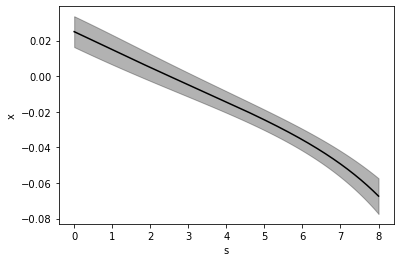

In [259]:
from matplotlib import pyplot

# x=0, y=1, z=2, px=3, py=4, dl=5
variable_names = ['x', 'y', 'z', 'px', 'py', 'δ']
plot_var_select = 0
all_approx=[ x_approx,
             y_approx,
             z_approx,
            px_approx,
            py_approx,
            dl_approx]

mean_q = ch.E(all_approx[plot_var_select], distribution)
variance_q = np.sum(
    z_approx_coeffs[:,plot_var_select*num_polys+1:(plot_var_select+1)*num_polys]**2,-1)

pyplot.xlabel("s")
pyplot.ylabel(variable_names[plot_var_select])
#pyplot.axis([0, 10, 0, 2])
pyplot.fill_between(tcoordinates, mean_q-variance_q**0.5,
                    mean_q+variance_q**0.5, color="k", alpha=0.3)
pyplot.plot(tcoordinates, mean_q, "k-")

[mean_q[:5].round(6), variance_q[:5].round(6)]


## Monte Carlo plotting

In [260]:
type(distribution.sample(200, rule='random'))

numpy.ndarray

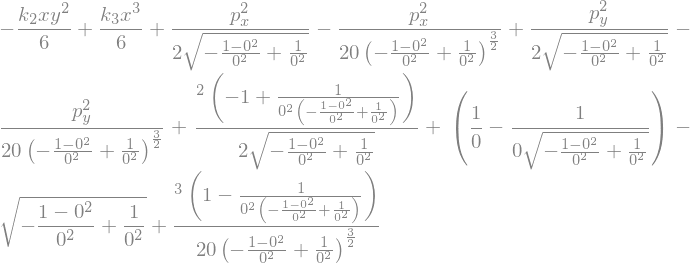

In [261]:
#q,p = sy.symbols('q, p')

#Ham(q,p,k0)
Hfodo(x,y,z,px,py,dl, k2,k3,b0)

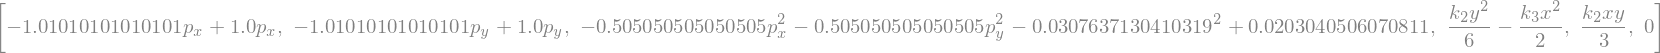

In [262]:
#origH_deriv_sign = {p: 1, q: -1}
origH_deriv_sign = {x: -1, y: -1, z: -1, px: 1, py: 1, dl: 1}
# The z array is switched, so that dx/dt = dH/dpx
origH_deriv_array_non_norm = [origH_deriv_sign[z]*sy.diff(Ham(x,y,z,px,py,dl, k2,k3,b0_value),z) for z in (px,py,dl,x,y,z)]
origH_deriv_array = origH_deriv_array_non_norm
origH_deriv_array

In [263]:
origH_var_list = [x,y,z,px,py,dl]
variating_params_list = [k2,k3,s2]
origH_var_params_list = origH_var_list+variating_params_list
origH_deriv_array_numeric = [sy.lambdify(origH_var_params_list, origH_deriv_array[i], 
                                         dummify = False, modules=["scipy", "numpy"]) 
                              for i in range(len(origH_var_list))]
origH_deriv_array_numeric[1]

<function _lambdifygenerated(x, y, z, p_x, p_y, δ, k2, k3, s2)>

In [264]:
def origH_derivative_field(t, y, *params):
    return np.array([origH_deriv_array_numeric[i](*y, *params) for i in range(len(origH_var_list))])
test_tuple = (0.1,0.1,0, 0,0,0)
origH_derivative_field(0, test_tuple, 1., 1., 1.)

array([ 0.        ,  0.        ,  0.        , -0.00333333,  0.00333333,
        0.        ])

In [265]:
#t0 = 0.
#tf = 1.5
t_span = (t0, tf)
y0 = init_cond_pce

#time_steps = 10000
tcoordinates = np.linspace(t_span[0], t_span[1], time_steps)

#y0_ham = init_cond_pce
n_samples = 200
# Sample only from distribution 1 (k0 = s0 distribution)
# param_samples = np.c_ [distribution1.sample(n_samples, rule='random'),
#                        distribution1.sample(n_samples, rule='random')]
xi0_samples = distribution1.sample(n_samples, rule='random')
xi1_samples = distribution2.sample(n_samples, rule='random')
xi2_samples = distribution3.sample(n_samples, rule='random')
param_samples = np.c_ [xi0_samples,xi1_samples,xi2_samples]

y0_ham = [[float(sy.sympify(init_cond_q[i]).subs([(s0,param_samples[j,0]), (s1,param_samples[j,1]), (s2,param_samples[j,2])])) for i in range(h_dims)] + \
            [float(sy.sympify(init_cond_p[i]).subs([(s0,param_samples[j,0]), (s1,param_samples[j,1]), (s1,param_samples[j,1]), (s2,param_samples[j,2])])) for i in range(h_dims)] for j in range(n_samples)]
y0_ham[0]
#param_samples

In [266]:
#[distribution1.sample(n_samples, rule='random')
y0_ham[2]

In [267]:
%%time
# Long!
# Dask version
# import dask as dk
# solham_vals = np.zeros(shape=(time_steps,len(origH_var_list),n_samples))
# solham_vals_list = []
# for i in range(n_samples):
#     solham = dk.delayed(sp.integrate.solve_ivp)(origH_derivative_field, t_span, y0_ham, args=(param_samples[i],), method='DOP853', rtol=1e-13, atol=1e-13, 
#                                     max_step=1/100, t_eval=tcoordinates, dense_output=True, events=None, vectorized=False)
#     solham_vals_list.append(solham)
# solham_vals_list = dk.compute(*solham_vals_list)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 14.3 µs


In [268]:
%%time
# for i in range(n_samples):
#     solham_vals[:,:,i] = solham_vals_list[i].sol(tcoordinates).T

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs


In [269]:
%%time
# No dask
import random
solham_vals = np.zeros(shape=(time_steps,len(origH_var_list),n_samples))
for i in range(n_samples):
    #solham = sp.integrate.solve_ivp(origH_derivative_field, t_span, y0_ham[random.sample(range(n_samples),1)[0]], args=param_samples[i], 
    solham = sp.integrate.solve_ivp(origH_derivative_field, t_span, y0_ham[i], args=param_samples[i], 
                                method='DOP853', rtol=1e-13, atol=1e-13, 
                                    max_step=1/100, t_eval=tcoordinates, 
                                    dense_output=True, events=None, vectorized=False)
    solham_vals[:,:,i] = solham.sol(tcoordinates).T

CPU times: user 1min 21s, sys: 14.9 ms, total: 1min 21s
Wall time: 1min 21s


In [270]:
solham_vals[:,0,:] # 0=x, 1=y, etc
#np.mean(solham_vals[:,0,:],axis=1)
np.shape(solham_vals)
solham_vals[:10,:,0]

array([[ 3.83699531e-02,  5.00000000e-02,  0.00000000e+00,
        -1.00000000e-02, -1.00000000e-02, -1.00000000e-02],
       [ 3.82890236e-02,  4.99191668e-02, -2.45932364e-06,
        -1.00100216e-02, -9.98621896e-03, -1.00000000e-02],
       [ 3.82080132e-02,  4.98384449e-02, -4.91834554e-06,
        -1.00199920e-02, -9.97248926e-03, -1.00000000e-02],
       [ 3.81269224e-02,  4.97578338e-02, -7.37706800e-06,
        -1.00299112e-02, -9.95881081e-03, -1.00000000e-02],
       [ 3.80457515e-02,  4.96773331e-02, -9.83549333e-06,
        -1.00397793e-02, -9.94518352e-03, -1.00000000e-02],
       [ 3.79645010e-02,  4.95969425e-02, -1.22936238e-05,
        -1.00495962e-02, -9.93160729e-03, -1.00000000e-02],
       [ 3.78831714e-02,  4.95166615e-02, -1.47514615e-05,
        -1.00593619e-02, -9.91808202e-03, -1.00000000e-02],
       [ 3.78017629e-02,  4.94364897e-02, -1.72090088e-05,
        -1.00690765e-02, -9.90460763e-03, -1.00000000e-02],
       [ 3.77202760e-02,  4.93564267e-02, -1.966

[array([0.025   , 0.024919, 0.024838, 0.024757, 0.024676, 0.024595,
        0.024514, 0.024433, 0.024353, 0.024272, 0.024191, 0.02411 ,
        0.024029, 0.023948, 0.023866, 0.023785, 0.023704, 0.023623,
        0.023542, 0.023461, 0.02338 , 0.023299, 0.023218, 0.023137,
        0.023056, 0.022975, 0.022894, 0.022812, 0.022731, 0.02265 ,
        0.022569, 0.022488, 0.022407, 0.022326, 0.022244, 0.022163,
        0.022082, 0.022001, 0.02192 , 0.021839, 0.021757, 0.021676,
        0.021595, 0.021514, 0.021433, 0.021351, 0.02127 , 0.021189,
        0.021108, 0.021027]),
 array([7.5e-05, 7.5e-05, 7.5e-05, 7.5e-05, 7.5e-05, 7.5e-05, 7.5e-05,
        7.5e-05, 7.5e-05, 7.5e-05, 7.5e-05, 7.5e-05, 7.5e-05, 7.5e-05,
        7.5e-05, 7.5e-05, 7.5e-05, 7.5e-05, 7.5e-05, 7.5e-05, 7.5e-05,
        7.5e-05, 7.5e-05, 7.5e-05, 7.5e-05, 7.5e-05, 7.5e-05, 7.5e-05,
        7.5e-05, 7.5e-05, 7.5e-05, 7.5e-05, 7.5e-05, 7.5e-05, 7.5e-05,
        7.5e-05, 7.4e-05, 7.4e-05, 7.4e-05, 7.4e-05, 7.4e-05, 7.4e-05,


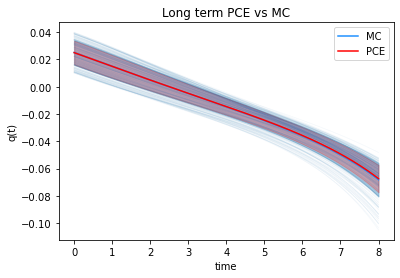

In [271]:
from matplotlib import pyplot

q_vals = solham_vals[:,0,:]
mean_q_mc = np.mean(solham_vals[:,0,:],axis=1)
var_q_mc = np.var(solham_vals[:,0,:],axis=1, ddof=1)

pyplot.xlabel("time")
pyplot.ylabel("q(t)")
#pyplot.axis([0, 10, 0, 2])
pyplot.plot(tcoordinates, q_vals, "-", color="tab:blue", lw=0.7, alpha=0.05)

pyplot.fill_between(tcoordinates, mean_q_mc-var_q_mc**0.5,
                    mean_q_mc+var_q_mc**0.5, color="tab:blue", alpha=0.3)

pyplot.plot(tcoordinates, mean_q_mc, "-", color="dodgerblue", alpha=1, label="MC")

pyplot.fill_between(tcoordinates, mean_q-variance_q**0.5,
                    mean_q+variance_q**0.5, color="tab:red", alpha=0.3)

#pyplot.plot(tcoordinates, q_approx(param_samples), "-", color="tab:red", lw=0.7, alpha=0.05)

#Averages
pyplot.plot(tcoordinates, mean_q, "-", color='red', alpha=1, label="PCE")

ax = pyplot.gca()
#ax.set(ylim=(-0.05, 0.5))
pyplot.legend(loc="upper right")
pyplot.title("Long term PCE vs MC")
pyplot.savefig(f"MonteCarlo.pdf")

[mean_q[:50].round(6), variance_q[:50].round(6)]

In [272]:
#q_approx(3)

## Point collocation unintrusive fit

In [273]:
print(polynomial_expansion.shape)
print(param_samples.shape)
print(solham_vals.transpose([2,1,0]).shape)
#allvar_samples = np.c_[param_samples[:,0], distribution2.sample(n_samples, rule='random')].T
allvar_samples = param_samples.T
print(allvar_samples.shape)

(4,)
(200, 3)
(200, 6, 1000)
(3, 200)


In [274]:
#solham_vals

In [275]:
x_solham_vals = solham_vals.transpose([2,1,0])[:,0,:]
y_solham_vals = solham_vals.transpose([2,1,0])[:,1,:]
z_solham_vals = solham_vals.transpose([2,1,0])[:,2,:]

px_solham_vals = solham_vals.transpose([2,1,0])[:,3,:]
py_solham_vals = solham_vals.transpose([2,1,0])[:,4,:]
dl_solham_vals = solham_vals.transpose([2,1,0])[:,5,:]

all_solham_vals = [x_solham_vals,
                  y_solham_vals,
                  z_solham_vals,
                  px_solham_vals,
                  py_solham_vals,
                  dl_solham_vals]

In [276]:
x_model_approximations = ch.fit_regression(polynomial_expansion, allvar_samples, x_solham_vals)
y_model_approximations = ch.fit_regression(polynomial_expansion, allvar_samples, y_solham_vals)
z_model_approximations = ch.fit_regression(polynomial_expansion, allvar_samples, z_solham_vals)

px_model_approximations = ch.fit_regression(polynomial_expansion, allvar_samples, px_solham_vals)
py_model_approximations = ch.fit_regression(polynomial_expansion, allvar_samples, py_solham_vals)
dl_model_approximations = ch.fit_regression(polynomial_expansion, allvar_samples, dl_solham_vals)

In [277]:
# all_model_approximations = [np.append(np.array(model_approximations[i].coefficients),
#                             np.array(p_model_approximations[i].coefficients))
#                            for i in range(1,time_steps)]

In [278]:
# p_model_approximations[23]

In [279]:
# len(pce_coeffs_var_list)

[array([0.025   , 0.024919, 0.024838, 0.024757, 0.024676]),
 array([7.5e-05, 7.5e-05, 7.5e-05, 7.5e-05, 7.5e-05])]

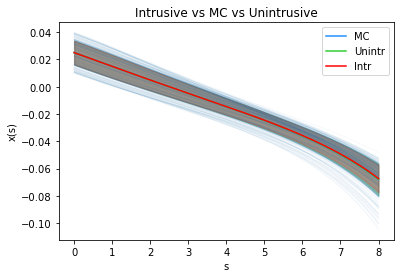

In [280]:
#model_approximations
from matplotlib import pyplot

# x=0, y=1, z=2, px=3, py=4, dl=5
#plot_var_select = 3
all_model_approximations=[x_model_approximations,
                      y_model_approximations,
                      z_model_approximations,
                      px_model_approximations,
                      py_model_approximations,
                      dl_model_approximations]

q_vals = solham_vals[:,plot_var_select,:]
mean_q_mc = np.mean(solham_vals[:,plot_var_select,:],axis=1)
var_q_mc = np.var(solham_vals[:,plot_var_select,:],axis=1, ddof=1)

unintr_mean_q = ch.E(
        all_model_approximations[plot_var_select], distribution)  
unintr_var_q  = ch.Var(
        all_model_approximations[plot_var_select], distribution)


pyplot.xlabel("s")
pyplot.ylabel(f"{variable_names[plot_var_select]}(s)")
#pyplot.axis([0, 10, 0, 2])
pyplot.plot(tcoordinates, q_vals, "-", color="tab:blue", lw=0.7, alpha=0.05)

pyplot.fill_between(tcoordinates, mean_q_mc-var_q_mc**0.5,
                    mean_q_mc+var_q_mc**0.5, color="tab:blue", alpha=0.3)

pyplot.plot(tcoordinates, mean_q_mc, "-", color="dodgerblue", alpha=1, label="MC")


#pyplot.plot(tcoordinates, q_approx(param_samples), "-", color="tab:red", lw=0.7, alpha=0.05)


#unintrusive
pyplot.fill_between(tcoordinates, unintr_mean_q-unintr_var_q**0.5,
                    unintr_mean_q+unintr_var_q**0.5, color="tab:green", alpha=0.3)
pyplot.plot(tcoordinates, unintr_mean_q, "-", color='limegreen', alpha=1, label="Unintr")

#intrusive
pyplot.fill_between(tcoordinates, mean_q-variance_q**0.5,
                    mean_q+variance_q**0.5, color="tab:red", alpha=0.3)
pyplot.plot(tcoordinates, mean_q, "-", color='red', alpha=1, label="Intr")



ax = pyplot.gca()
#ax.set(ylim=(-0.05, 0.5))
pyplot.legend(loc="upper right")
pyplot.title("Intrusive vs MC vs Unintrusive")
pyplot.savefig(f"Unintrusive_fit_{variable_names[plot_var_select]}.pdf")

[mean_q[:5].round(6), variance_q[:5].round(6)]

In [281]:
c_hat_tot = np.empty(shape=(0,time_steps))
for i in range(h_dims*2):
    phi = polynomial_expansion(*allvar_samples).T #allvar_samples, q_solham_vals
    ptp = phi.T @ phi
    pty = phi.T @ solham_vals.transpose([2,1,0])[:,i,:]
    c_hat = np.linalg.inv(ptp) @ pty
    c_hat_tot = np.r_[c_hat_tot,c_hat]
c_hat_tot.shape

In [282]:
# pty_p = phi.T @ p_solham_vals
# c_hat_p = np.linalg.inv(ptp) @ pty_p
# c_hat_p.shape

[array([0.025   , 0.024919, 0.024838, 0.024757, 0.024676]),
 array([7.5e-05, 7.5e-05, 7.5e-05, 7.5e-05, 7.5e-05])]

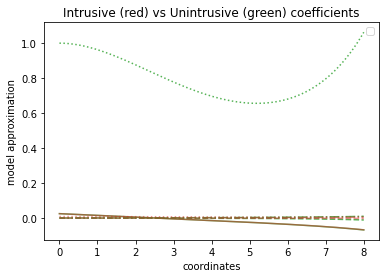

In [283]:
pyplot.xlabel("coordinates")
pyplot.ylabel("model approximation")
#pyplot.axis([0, 10, 0, 2])
# pyplot.fill_between(tcoordinates, mean_q-variance_q**0.5,
#                     mean_q+variance_q**0.5, color="k", alpha=0.3)
# Todo why numpoly-1 dimensions in c_hat and not numpoly
styles = ['solid', 'dotted', 'dashed', 'dashdot']
colors = ['blue', 'orange', 'green', 'red', 'purple',
          'brown', 'pink', 'gray', 'olive', 'cyan']
for i in range(num_polys):
    pyplot.plot(tcoordinates, c_hat_tot[3*plot_var_select+i,:], color="tab:green", 
                label="", 
                ls=styles[i%len(styles)], #c = f"tab:{colors[i]}", 
                alpha=0.8)
    pyplot.plot(tcoordinates, z_approx_coeffs[:,3*plot_var_select+i],  color="tab:red", 
                label="", 
                ls=styles[i%len(styles)], #c = f"tab:{colors[i]}", 
                alpha=0.5)

pyplot.legend(loc="upper right")
pyplot.title("Intrusive (red) vs Unintrusive (green) coefficients")
pyplot.savefig(f"Intr_vs_Unintr_Qs.pdf")

[mean_q[:5].round(6), variance_q[:5].round(6)]

In [672]:
#c_hat_tot = np.r_[c_hat,c_hat_p]
z_approx_coeffs.shape

In [673]:
c_hat_tot.shape

## Various

In [ ]:
test = s0**2
test.subs([(s0,s1)])

In [ ]:
psic(2,k0,s0)

In [ ]:
t0 = sy.symbols("t0", real=True)
t1 = sy.symbols("t1", real=True ,nonnegative=True)

In [ ]:
Q[0] = sy.Function("Qf[0]", real=True)

In [ ]:
Qf0(t0)

In [ ]:
sy.__version__

In [ ]:
x = sy.symbols('x', real=True)
EI1,EI2 = sy.symbols('EI1 EI2')
u1,u2 = sy.symbols('u1 u2', cls=sy.Function)

eq = [sy.Eq(EI1*sy.diff(u1(x),x), 12*x*u1(x) + 8*u2(x)), sy.Eq(EI2*sy.diff(u2(x),x), 21*u1(x) + 7*x*u2(x))]
print(eq)
print(sy.classify_ode(eq[0]))
sol = sy.dsolve(eq)
sol

In [ ]:
del EI1,EI2,u1,u2,eq

In [ ]:
{**{'d': 1, 'e': 2}, **{'c': 3}}

In [ ]:
sy.derive_by_array

In [ ]:
sy.factorial(2)

In [ ]:
q

In [ ]:
sy.integrate(sy.exp(q**2+p**2),*origH_var_list)

In [ ]:
origH_var_list

In [ ]:
sy.Number(1)/(sigma*sy.sqrt(2*sy.pi)).evalf()

In [ ]:
gaussdensity(s0, mu, sigma, numerical=True).evalf()

## Numpoly and Jax tests

In [ ]:
import numpoly as ny
import jax as jx
import jax.numpy as jnp
import numpy as np
# from jax import grad, jit, vmap
# from jax import random


q0, q1, q2 = ch.variable(3)

In [ ]:
pp = q0+q1**2-q2

In [ ]:
ny.gradient(pp)

In [ ]:
ch.E(q0,distribution)

In [ ]:
H1_func(pp,pp,1)

In [ ]:
dH1_func = jx.jit(jx.grad(H1_func,[0,1]))

In [ ]:
dH1_func(1.,1.,0.5)[0]

In [ ]:
print(H1_func(1.,3.,5.))
print(H1_func(2.,4.,6.))
H1_func(jnp.array([1.,2.]), jnp.array([3.,4.]), jnp.array([5.,6.]))


### Integral derivative

In [ ]:
def num_integral(func, points, weights):
    return np.sum(weights*func(points))
    

In [76]:
abscissas, weights = ch.generate_quadrature(order=30, dist=distribution)
print(abscissas)
#print(weights)

[[1.5        1.5        1.5        ... 3.5        3.5        3.5       ]
 [3.         3.00273905 3.0109262  ... 3.9890738  3.99726095 4.        ]]


In [ ]:
func_args = np.r_[abscissas,np.array([[3.]*abscissas.shape[1]])]

In [ ]:
H1_np = lambda arr: H1_func(arr[0,:], arr[1,:], arr[2,:])

In [ ]:
%time
int_out = num_integral(H1_np, func_args, weights)
int_out

In [ ]:
sy.integrate(H1(s0,s1,3)*sy_dist_pdf(s0,s1), *sy_omega).evalf()

In [ ]:
int_out

In [ ]:
dH1_func = jx.grad(num_integral,1)

In [ ]:
dH1_func(H1_np, np.r_[abscissas,np.array([[5.]*abscissas.shape[1]])], weights)

In [ ]:
sy.integrate(H1(s0,s1,3)*sy_dist_pdf(s0,s1), sy_omega[0]).evalf()

In [ ]:
test_polyeval = lambda a,b,c: pp(a,b,c)

In [ ]:
#import numpy as np
pp_coeff = jnp.array(pp.coefficients)
pp_expon = jnp.array(pp.exponents)
pp_eval = jx.jit(lambda var_vals: jnp.sum(pp_coeff*jnp.prod(var_vals**pp_expon, -1)))
pp_eval(jnp.array([[4.,2.,3.]]))

pp_coeff = jnp.array(pp.coefficients)
pp_expon = jnp.array(pp.exponents)
pp_eval = jx.jit(lambda var_vals: jnp.sum(pp_coeff*jnp.prod(var_vals**pp_expon, -1)))
pp_eval(jnp.array([[4.,2.,3.]]))

In [ ]:
dpp_eval = jx.jit(jx.grad(pp_eval))
dpp_eval(jnp.array([[4.,7.,3.]]))

In [ ]:
ch.gradient(pp)(4.,7.,3.)

In [ ]:
pp

In [ ]:
ch.gradient(pp)(q1=7.)

In [ ]:
pp(4.,2.,3.)

In [ ]:
pp_coeff

In [ ]:
pp_expon

In [ ]:
H1_func(pp,pp,q0)

In [ ]:
qs = ch.variable(20)

In [ ]:
polynomial_expansion

In [ ]:
ch.symbols("q100:110")

In [ ]:
qqnum = ch.sum(ch.symbols(f"q100:{100+len(polynomial_expansion)}")*polynomial_expansion)
ppnum = ch.sum(ch.symbols(f"q200:{200+len(polynomial_expansion)}")*polynomial_expansion)

In [ ]:
testdict = {'q0': 1.,'q1': 1.}
qqnum(**testdict)(q100=q0)

In [ ]:
%%time

numpoly_H1 = H1_func(qqnum,ppnum,q0)
#numpoly_H1

In [ ]:
y0_polytest = [0.]*(2*num_polys)
y0_polytest[0]=1.
y0_polytest[3]=1.
y0_polytest[4]=1.
y0_polytest = np.array(y0_polytest)

polyeval_vars_list   = [f"q{var+i}" for var in [100, 200] for i in range(num_polys)]
q_polyeval_vars_list = polyeval_vars_list[0:num_polys]
p_polyeval_vars_list = polyeval_vars_list[num_polys:2*num_polys]

In [ ]:
q_y0_polytest = y0_polytest[0:num_polys]
p_y0_polytest = y0_polytest[num_polys:2*num_polys]

In [ ]:
q_test_polydict = dict(zip(q_polyeval_vars_list,q_y0_polytest))
q_test_polydict

In [ ]:
tqq = qqnum(**q_test_polydict)
tqq.exponents
# Non toglie dal polinomio le variabili sostituite...

In [ ]:
# TODO finire
@jx.jit
def poly_eval(var_vals, coeff, expon):
    return jnp.sum(coeff*jnp.prod(var_vals**expon, -1))
dpoly_eval = jx.jit(jx.grad(poly_eval))
poly_eval_lam = lambda var_vals: poly_eval(var_vals, tqq.coefficients, tqq.exponents)
#poly_eval(jnp.array([3.,4.]),tqq.coefficients,tqq.exponents)
poly_eval_lam(jnp.array([3.,4.,5.]))

In [ ]:
def fast_num_derivative(t, y):
    #keys_list = ["a", "b"]
    q_polyexp_coeffs_dict = dict(zip(q_polyeval_vars_list, y[0:num_polys]))
    p_polyexp_coeffs_dict = dict(zip(p_polyeval_vars_list, y[num_polys,2*num_polys]))
    H1_QP = H1_func(qqnum(q_polyexp_coeffs_dict),ppnum(p_polyexp_coeffs_dict),q0)
    dpoly_eval = jx.grad
    out = num_integral(poly_eval(), 
                       abscissas, weights)
    return out 
    #zi_coeffs_dict = dict(zip_iterator)

In [ ]:
str(Htilde)

In [ ]:
from pathlib import Path
Htilde_str = Path('Hhat_5_srepr.txt').read_text()
Htilde_str;

In [ ]:
Htilde_asread = sy.sympify(Htilde_str)

In [ ]:
Htilde_asread - Htilde

In [ ]:
[(i,j) for i in range(10,13) for j in range(20,23)]

In [ ]:
tttt = np.array([[1,2,3],[4,5,6],[7,8,9]])
aaaa = np.array([1,2,3])
aaaa[:6]

In [ ]:
tttt = ch.monomial(
            0,
            5,
            names=ch.variable(3).names,
            graded=True,
            reverse=True,
            cross_truncation=1.,
        )

In [ ]:
tttt[1]

In [ ]:
sy_dist_pdf(*ch_to_sy(numpoly.variable(2)))

In [ ]:
ch_to_sy(tttt)

In [ ]:
from functools import reduce
import operator
reduce(operator.mul, [s0,s1,s2,s2], 1)

In [281]:
Hhat1 = sy.sympify(Path(f"Hhat_d{3}_o{2}_srepr.txt").read_text())
#Hhat1

In [421]:
tttt = np.empty(shape=(1,2))
tttt

array([[5.e-324, 5.e-324]])

In [530]:
num_polys

In [608]:
'expansion_order' in globals()

True

In [214]:
float(sy.N(3))

In [357]:
from sympy.utilities.lambdify import lambdastr
lambdastr(x,sy.summation(weights[D]*sy.sin(points[D]),(D,0,len(abscissas))))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
np.sum(weights*func(points))

In [356]:
len(abscissas)

In [356]:
sy.Function

In [ ]:
class my_sum(sy.Function): 
     @classmethod
#     def eval(cls, x):
#          np.sum(weights*func(points))
     def _eval_evalf(cls, prec):
        x = self.args[0]
    

In [70]:
PCEvars_list

In [125]:
init_cond_pce
test_numeval = sy.lambdify([[xi0,xi1],PCEvars_list],deriv_array[0].evalf(), modules=["scipy", "numpy"])

In [128]:
test_numeval_int = lambda y, weights, abscissas: np.sum(weights*test_numeval(abscissas,y))
test_numeval_int(init_cond_pce, weights, abscissas)

In [358]:
np.sum(weights*func(points))

NameError: name 'func' is not defined

In [ ]:
f = implemented_function('f', lambda expr: np.sum(weights*func(points)))

In [72]:
(lambda x: x**2)(2)

In [97]:
[tt1, tt2] = abscissas


In [99]:
#tt1

In [103]:
xi1